## Здесь попробуем некоторые претренированные модели

### FashionCLIP
Модель основанная на CLIP от OpenAI, генерирующая общее векторное представление в латентном пространстве для текстового и графического описания каждого объекта

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from tqdm import tqdm
import torch
import torch.nn.functional as F
import pandas as pd
from collections import Counter
import numpy as np
from PIL import Image
from sklearn.metrics import classification_report

скачаем датасет c kaggle [соревнования](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations)

In [66]:
# !gdown "1igAuIEW_4h_51BG1o05WS0Q0-Cp17_-t&confirm=t"

In [67]:
# !pip install -U fashion-clip

In [72]:
from fashion_clip.fashion_clip import FashionCLIP

model = FashionCLIP('fashion-clip')

loading configuration file config.json from cache at C:\Users\Nikita\.cache\huggingface\hub\models--patrickjohncyh--fashion-clip\snapshots\ead6cba5fe7ab8c333b5a3ae4d420f253deab0f9\config.json
`text_config` is `None`. Initializing the `CLIPTextConfig` with default values.
`vision_config` is `None`. initializing the `CLIPVisionConfig` with default values.
Model config CLIPConfig {
  "architectures": [
    "CLIPModel"
  ],
  "initializer_factor": 1.0,
  "logit_scale_init_value": 2.6592,
  "model_type": "clip",
  "projection_dim": 512,
  "text_config": {
    "bos_token_id": 0,
    "dropout": 0.0,
    "eos_token_id": 2,
    "model_type": "clip_text_model"
  },
  "torch_dtype": "float32",
  "transformers_version": "4.36.2",
  "vision_config": {
    "dropout": 0.0,
    "model_type": "clip_vision_model"
  }
}

loading weights file model.safetensors from cache at C:\Users\Nikita\.cache\huggingface\hub\models--patrickjohncyh--fashion-clip\snapshots\ead6cba5fe7ab8c333b5a3ae4d420f253deab0f9\model.

In [16]:
articles = pd.read_csv("data/data_for_fashion_clip/articles.csv")

# удаляем дубликаты
subset = articles.drop_duplicates("detail_desc").copy()

# удаляем объекты с неизвестной категорией
subset = subset[~subset["product_group_name"].isin(["Unknown"])]

# модель имеет ограничением в 77 токенов, с запасом ограничим все описания на 50
subset = subset[subset["detail_desc"].apply(lambda x : 4 < len(str(x).split()) < 50)]

# удалим объекты с редкими категориями 
most_frequent_product_types = [k for k, v in dict(Counter(subset["product_type_name"].tolist())).items() if v > 10]
subset = subset[subset["product_type_name"].isin(most_frequent_product_types)]

subset.head(5)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,176754003,176754,2 Row Braided Headband (1),74,Hair/alice band,Accessories,1010016,Solid,17,Yellowish Brown,...,Hair Accessories,C,Ladies Accessories,1,Ladieswear,66,Womens Small accessories,1019,Accessories,Two-strand hairband with braids in imitation s...
3,189634031,189634,Long Leg Leggings,273,Leggings/Tights,Garment Lower body,1010016,Solid,93,Dark Green,...,Basic 1,D,Divided,2,Divided,51,Divided Basics,1002,Jersey Basic,Leggings in stretch jersey with an elasticated...
4,194270044,194270,HELENA 2-pack tanktop,253,Vest top,Garment Upper body,1010016,Solid,51,Light Pink,...,Young Girl Jersey Basic,I,Children Sizes 134-170,4,Baby/Children,79,Girls Underwear & Basics,1002,Jersey Basic,Tops in soft organic cotton jersey.
5,203027047,203027,Linni tee (1),255,T-shirt,Garment Upper body,1010017,Stripe,10,White,...,Basic 1,D,Divided,2,Divided,51,Divided Basics,1002,Jersey Basic,Short-sleeved top in jersey with sewn-in turn-...


In [18]:
subset.to_csv("data/data_for_fashion_clip/subset_data.csv", index=False)
f"Получили подмножество из датасета размером {len(subset)} элементов"

'Получили подмножество из датасета размером 3335 элементов'

#### Рекомендация по тексту
Для начала рассмотрим задачу являющуюся простым частным случаем описанной в тексте работы задачи восстановления образа -- рекомендация единственного объекта по его описанию -- т.е. по сути восстановления образа размера 1 по его текстовому описанию.

In [22]:
images = ["data/data_for_fashion_clip/" + str(k) + ".jpg" for k in subset["article_id"].tolist()]
texts = subset["detail_desc"].tolist()

# Получаем эмбединнги изображений и описаний
image_embeddings = model.encode_images(images, batch_size=32)
text_embeddings = model.encode_text(texts, batch_size=32)

# нормализуем полученные эмбединнги, чтобы использщовать скалярное произведение вместо косинусной близости
image_embeddings = image_embeddings/np.linalg.norm(image_embeddings, ord=2, axis=-1, keepdims=True)
text_embeddings = text_embeddings/np.linalg.norm(text_embeddings, ord=2, axis=-1, keepdims=True)

105it [02:28,  1.41s/it]                                                                                                                
  0%|                                                                                                           | 0/104 [23:09<?, ?it/s]


Map:   0%|          | 0/3335 [00:00<?, ? examples/s]

105it [00:09, 10.86it/s]                                                                                                                


Посчитаем top10-precision 

In [24]:
precision = 0

for index, t in enumerate(text_embeddings):
    arr = t.dot(image_embeddings.T)

    best = arr.argsort()[-10:][::-1]   

    if index in best:
        precision +=1

round(precision/len(text_embeddings), 2)

0.65

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 83.31it/s]


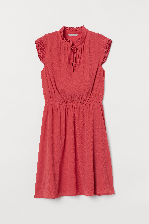

In [29]:
text_embedding = model.encode_text(["a red dress"], 32)[0]

id_of_matched_object = np.argmax(text_embedding.dot(image_embeddings.T))
found_object = subset["article_id"].iloc[id_of_matched_object].tolist()

fixed_height = 224

image = Image.open(f"data/data_for_fashion_clip/{found_object}.jpg")
height_percent = (fixed_height / float(image.size[1]))
width_size = int((float(image.size[0]) * float(height_percent)))
image = image.resize((width_size, fixed_height), Image.NEAREST)

image

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 66.66it/s]


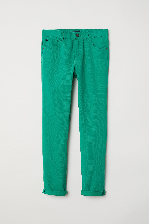

In [80]:
text_embedding = model.encode_text(["a green jeans"], 32)[0]

id_of_matched_object = np.argmax(text_embedding.dot(image_embeddings.T))
found_object = subset["article_id"].iloc[id_of_matched_object].tolist()

fixed_height = 224

image = Image.open(f"data/data_for_fashion_clip/{found_object}.jpg")
height_percent = (fixed_height / float(image.size[1]))
width_size = int((float(image.size[0]) * float(height_percent)))
image = image.resize((width_size, fixed_height), Image.NEAREST)

image

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 90.96it/s]


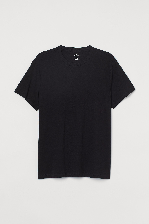

In [81]:
text_embedding = model.encode_text(["a black t-shirt"], 32)[0]

id_of_matched_object = np.argmax(text_embedding.dot(image_embeddings.T))
found_object = subset["article_id"].iloc[id_of_matched_object].tolist()

fixed_height = 224

image = Image.open(f"data/data_for_fashion_clip/{found_object}.jpg")
height_percent = (fixed_height / float(image.size[1]))
width_size = int((float(image.size[0]) * float(height_percent)))
image = image.resize((width_size, fixed_height), Image.NEAREST)

image

#### Классификация элементов по категориям
Небольшая подзадача задачи описания образа и/или элемента -- выбор наиболее подходящей к изображению категории из предложенных.

In [32]:
labels = subset["product_type_name"].unique()
print(f"Категории:\n {labels}")

Категории:
 ['Vest top' 'Hair/alice band' 'Leggings/Tights' 'T-shirt' 'Sneakers'
 'Sunglasses' 'Cardigan' 'Gloves' 'Underwear Tights' 'Hoodie' 'Other shoe'
 'Shorts' 'Jumpsuit/Playsuit' 'Dress' 'Trousers' 'Belt' 'Socks'
 'Underwear bottom' 'Bodysuit' 'Hat/beanie' 'Scarf' 'Jacket'
 'Other accessories' 'Bra' 'Swimwear bottom' 'Blazer' 'Top' 'Polo shirt'
 'Sweater' 'Necklace' 'Pyjama set' 'Blouse' 'Bag' 'Shirt' 'Coat' 'Boots'
 'Skirt' 'Garment Set' 'Bikini top' 'Sandals' 'Dungarees' 'Earring'
 'Cap/peaked' 'Ballerinas' 'Swimsuit' 'Hat/brim']


In [33]:
labels_prompt = [f"a photo of a {k}" for k in labels]

label_embeddings = model.encode_text(labels_prompt, batch_size=32)
label_embeddings = label_embeddings/np.linalg.norm(label_embeddings, ord=2, axis=-1, keepdims=True)

Map:   0%|          | 0/46 [00:00<?, ? examples/s]

2it [00:00, 11.09it/s]                                                                                                                  


In [35]:
predicted_classes_distribution = label_embeddings.dot(image_embeddings.T)
predicted = [labels[k] for k in np.argmax(predicted_classes_distribution, axis=0)]
print(classification_report(subset["product_type_name"], predicted))

                   precision    recall  f1-score   support

              Bag       0.97      0.84      0.90        45
       Ballerinas       0.67      0.15      0.25        13
             Belt       0.76      0.93      0.84        14
       Bikini top       0.62      0.74      0.67        38
           Blazer       0.94      0.85      0.89        40
           Blouse       0.48      0.80      0.60       151
         Bodysuit       0.53      0.65      0.59        26
            Boots       0.91      0.65      0.75        31
              Bra       0.92      0.74      0.82        76
       Cap/peaked       0.95      0.86      0.90        21
         Cardigan       0.57      0.86      0.68        50
             Coat       0.14      0.92      0.24        12
            Dress       0.92      0.76      0.83       344
        Dungarees       0.36      0.71      0.48        14
          Earring       0.98      0.84      0.90        55
      Garment Set       0.80      0.19      0.30       

#### Визуализация полученных эмбеддингов

In [38]:
import umap

reducer = umap.UMAP()
umap_embeddings = reducer.fit_transform(image_embeddings)

In [45]:
classes = subset["product_group_name"].tolist()

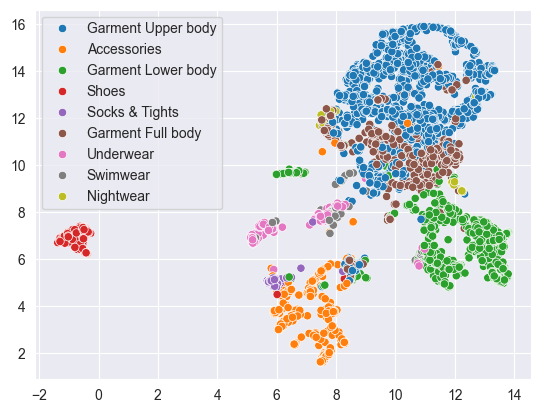

In [51]:
sns.scatterplot(x=umap_embeddings[:,0], y=umap_embeddings[:,1], hue=classes)
plt.show()